In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import gradcheck
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import shift
from math import sqrt
from scipy.sparse import diags
from scipy.linalg import cholesky

## Create MATRIX data

In [2]:
Nx, Nt, sigma = 250, 100, 5.0
coefficients1 = [-3,5] #[2,-1,-1]
coefficients2 = [0.1,0,0.8,-1.5] # of the shift polynomial
coefficients3 = [0.03,0.06,-2,-1,1]
center_of_matrix1 = 20
center_of_matrix2 = Nx//2
center_of_matrix3 = 50

In [3]:
def generate_data(Nx, Nt, center_of_matrix, coefficients):
    sigma = 5.0
    x = np.arange(0, Nx)
    t = np.linspace(-10, 10, Nt)
    [X, T] = np.meshgrid(x, t)
    X = X.T
    T = T.T    

    def gaussian(x, mu, sigma=1.0):
        return np.exp(-np.power(x - mu, 2.0) / (2 * np.power(sigma, 2.0)))

    Q = np.zeros_like(X, dtype=np.float64)
    shift1 = np.polyval(coefficients, t)
    for col in range(Nt):
        for row in range(Nx):
            Q[row, col] = gaussian(row, center_of_matrix + shift1[col], sigma)
    Q /= np.max(Q)
    
    return Q, x, t

In [4]:
Q, x, t = generate_data(Nx, Nt, center_of_matrix2, coefficients1)

Text(0.5, 1.0, 'Snapshot Matrix with shift')

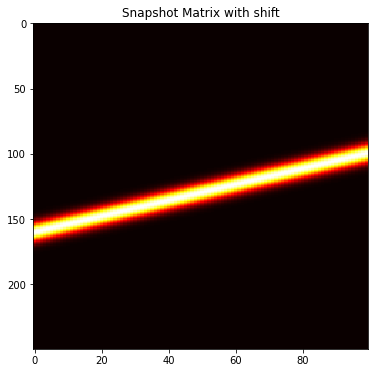

In [5]:
# Plotting
fig, ax = plt.subplots(figsize=(6, 6))

# Without shift
ax.imshow(Q, cmap='hot', interpolation='nearest', aspect='auto')
ax.set_title('Snapshot Matrix with shift')

## Define a model

In [6]:
class ShiftLearningNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ShiftLearningNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.elu1 = nn.ELU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.elu2 = nn.ELU()
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, t):
        hidden = self.elu1(self.fc1(t))
        hidden = self.elu2(self.fc2(hidden))
        shift = self.fc3(hidden)
        return shift

class ShapeLearningNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, center_of_matrix, sigma):
        super(ShapeLearningNetwork, self).__init__()
        self.center_of_matrix = center_of_matrix
        self.sigma = sigma #+ 3 layers ELU ac
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.elu1 = nn.ELU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.elu2 = nn.ELU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.elu3 = nn.ELU()
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.elu4 = nn.ELU()
        self.fc5 = nn.Linear(hidden_size, output_size)
        self.shift_net = ShiftLearningNetwork(input_size=1, hidden_size=hidden_size, output_size=1)

        self.fc1.weight.data.normal_(0, sigma)
        self.fc1.bias.data.fill_(center_of_matrix)

    def forward(self, x, t):
        shift = self.shift_net(t)
        x_shifted = x - shift
        combined_input = torch.cat((x_shifted, t), dim=1)
        x = self.elu1(self.fc1(combined_input))
        x = self.elu2(self.fc2(x))
        x = self.elu3(self.fc3(x))
        x = self.elu4(self.fc4(x))
        output = self.fc5(x)
        return output


## Train a model

Matrix structure as input?

In [7]:
Q_tensor = torch.tensor(Q, dtype=torch.float32)
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(-1)
t_tensor = torch.tensor(t, dtype=torch.float32).unsqueeze(-1)

inputs = torch.cat((
    x_tensor.repeat(1, len(t)).reshape(-1, 1),
    t_tensor.repeat(len(x), 1)
), dim=1)

dataset = TensorDataset(inputs, Q_tensor.reshape(-1, 1))
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
shape_net = ShapeLearningNetwork(input_size=2, hidden_size=50, output_size=1, center_of_matrix=Nx//2, sigma=5.0)

optimizer = optim.Adam(shape_net.parameters(), lr=0.001)

epochs = 200

for epoch in range(epochs):
    running_loss = 0.0
    for inputs_batch, targets_batch in dataloader:
        optimizer.zero_grad()

        x_batch = inputs_batch[:, 0].unsqueeze(-1)
        t_batch = inputs_batch[:, 1].unsqueeze(-1)

        outputs = shape_net(x_batch, t_batch)

        loss = torch.norm(targets_batch-outputs,'fro')

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {running_loss / len(dataloader)}')
        running_loss = 0.0

print('Finished Training') 

Epoch 1, Loss: 1.8064737042502674
Epoch 11, Loss: 0.16530965567302064
Epoch 21, Loss: 0.1058305795923771
Epoch 31, Loss: 0.0780831849478814
Epoch 41, Loss: 0.08464921259468951
Epoch 51, Loss: 0.07049789091082685
Epoch 61, Loss: 0.06237798117820526
Epoch 71, Loss: 0.05506097408287856
Epoch 81, Loss: 0.059741379485329815



KeyboardInterrupt



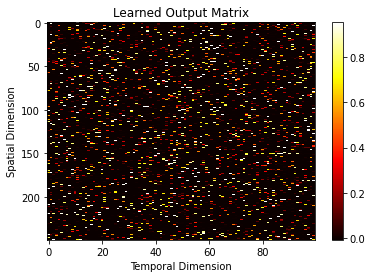

In [9]:
shift_net = ShiftLearningNetwork(input_size=1, hidden_size=100, output_size=1)
shape_net.eval()
shift_net.eval()

all_outputs = []
with torch.no_grad():
    for inputs_batch, _ in dataloader:
        x_batch = inputs_batch[:, 0].unsqueeze(-1)
        t_batch = inputs_batch[:, 1].unsqueeze(-1)
        shifts = shift_net(t_batch)
        shifted_x_batch = x_batch - shifts
        outputs = shape_net(shifted_x_batch, t_batch)
        all_outputs.append(outputs)

all_outputs = torch.cat(all_outputs).view(Nx, Nt)

all_outputs_np = all_outputs.numpy()

plt.imshow(all_outputs_np, cmap='hot', interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Learned Output Matrix')
plt.xlabel('Temporal Dimension')
plt.ylabel('Spatial Dimension')
plt.show()
